# Connect Four AI

Wassup! I have no idea what I'm doing, but here goes.

So I _finally_ coded up a working Connect Four game in Python, and now comes the fun part. I'm going to follow the style of the tutorial on Medium and start with a simple Q-table implementation.

In [1]:
from ConnectFour import Game
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

g = Game()

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Above is a sample output of what the computer gets for each move: a "reward" (only nonzero when you win/lose), the state of the board, and an indication of whether the game is over or not.

## Constructing the Neural Network

In [30]:
# constructing the network
tf.reset_default_graph()
inputs = tf.placeholder(shape=[1,84], dtype=tf.float32) # the input is the current state, i.e. the entire board
layers = [84, 20, 20, 7]
weights = {}
biases = {}
layer = {}
for i in range(len(layers) - 1):
    weights[i] = tf.Variable(tf.random_uniform([layers[i], layers[i+1]], 0, 0.1))
    biases[i] = tf.Variable(tf.random_uniform([1, layers[i+1]], 0, 0.1))
    if i is 0:
        layer[i] = tf.matmul(inputs, weights[i])
    else:
        layer[i] = tf.matmul(layer[i-1], weights[i])
    # add bias to hidden layer
    layer[i] += biases[i]
    # apply relu function to hidden layers, not to output
    if i < len(layers) - 1:
        layer[i] = tf.nn.relu(layer[i])

Qout = layer[len(layers) - 2]
predict = tf.argmax(Qout, 1) # finding best predicted action from Qout

# constructing the loss function
nextQ = tf.placeholder(shape=[1,7], dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
updateModel = trainer.minimize(loss)

# some magic initializer or something, and a saver
init = tf.global_variables_initializer()
saver = tf.train.Saver()

# hyperparameters
y = 0.75 # discount rate for Bellman equation
e = 0.2 # chance of random action being taken

## Running the Model

In [31]:
n_episodes = 1000
jList = np.zeros(n_episodes) # number of steps for each game
rList = np.zeros(n_episodes) # maximum reward for each game

model_num = 1

with tf.Session() as sess:
    sess.run(init)
    
    print('weights are: ')
    print(sess.run(weights))
    print('biases are: ')
    print(sess.run(biases))
    
    # restore if I'm picking up from a previously saved model
#    saver.restore(sess, "./saved/model_1")
    
    for i in range(n_episodes):
        if i%50 is 0:
            print('On episode {}'.format(i))
        
        # reset the game
        g.reset()
        rAll = 0
        d = False
        j = 0
        sPrev = None # the previous state at turn's start for the opposing player
        aPrev = None # the previous action by opposing player
        allQPrev = None # the previous set of Q values for opposing player
        maxQ1Prev = None # the maximum predicted Q value after action by opposing player
        while j < 99:
            j += 1
            s = g.getState()
            allQ = sess.run([Qout], feed_dict={inputs:s.reshape((1,84))})
            actions = np.argsort(-allQ)[0] # I think this will work
            # pick a random move e% of the time
            if np.random.rand(1) < e:
                actions[0] = np.random.randint(7) 
            # make the move, get the reward/next state
            while True: # ensures it makes a move
                try:
                    s1, r, d = g.play(actions[0])
                    break
                except:
                    # first check if game is still playable
                    if g.isPlayable():
                        actions = actions[1:]
                    else:
                        s1 = s
                        r = 0
                        d = True
                        break
            # train the model based on the reward the person got
            Q1 = sess.run(Qout, {inputs:s1.reshape((1,84))})
            maxQ1 = np.max(Q1)
            targetQ = allQ
            # not sure why it's 0, a[0] here... Wait, I think it's because
            # targetQ is 1x7 vector, and only want to update the Q value for
            # the given state/action pair
            targetQ[0, a[0]] = r + y*maxQ1
            # train model based on new value
            _, W1 = sess.run([updateModel, weights], {inputs: s.reshape((1,84)), nextQ: targetQ})
            
            # penalize bad moves by players if the other one wins
            if sPrev is not None and r > 0:
                targetQ = allQPrev
                targetQ[0, aPrev[0]] = -r + y*maxQ1Prev
                _, W1 = sess.run([updateModel, weights], {inputs: sPrev.reshape((1,84)), nextQ: targetQ})
            
            # keep track of total rewards (will be 1/game if someone wins)
            rAll += r
            
            # keep track of the player's state and moves
            sPrev = s
            aPrev = a
            allQPrev = allQ
            maxQ1Prev = maxQ1
            if d:
                e = 1. / ((i/50.) + 10)
                break
        
        jList[i] = j
        rList[i] = rAll
    
    # save the current model and vars to file
    savePath = saver.save(sess, './saved/model_{}'.format(model_num))
    print('Trained model saved to {}'.format(savePath))

print('Percent successful episodes: {}%'.format(sum(rList > 0)/n_episodes * 100))

weights are: 
{0: array([[ 0.05452223,  0.08580621,  0.03087331, ...,  0.01159142,
         0.04784585,  0.04488233],
       [ 0.03386084,  0.02670542,  0.09607755, ...,  0.04769924,
         0.03955599,  0.01826462],
       [ 0.0800634 ,  0.02618468,  0.0695514 , ...,  0.07790766,
         0.03335741,  0.03501933],
       ..., 
       [ 0.00138735,  0.06062324,  0.06954318, ...,  0.04599366,
         0.07790196,  0.0303719 ],
       [ 0.02023797,  0.04125898,  0.00477196, ...,  0.06124842,
         0.08910985,  0.08714246],
       [ 0.01869466,  0.07751876,  0.03376674, ...,  0.04388571,
         0.08855609,  0.05293917]], dtype=float32), 1: array([[  9.73764807e-02,   9.51573849e-02,   8.67581517e-02,
          3.56625323e-03,   2.08233595e-02,   1.19364141e-02,
          5.17622605e-02,   9.27647874e-02,   7.63127804e-02,
          1.20403769e-03,   9.34387445e-02,   1.57581456e-02,
          3.42170009e-03,   2.79400358e-03,   8.01969171e-02,
          7.73664266e-02,   1.74805764e

On episode 50
On episode 100
On episode 150
On episode 200
On episode 250
On episode 300
On episode 350
On episode 400
On episode 450
On episode 500
On episode 550
On episode 600
On episode 650
On episode 700
On episode 750
On episode 800
On episode 850
On episode 900
On episode 950
Trained model saved to ./saved/model_1
Percent successful episodes: 98.9%


## Looking at the Results

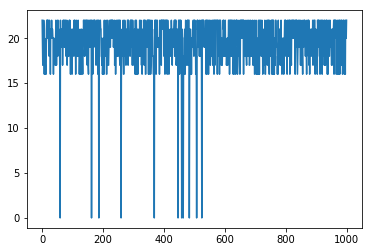

In [36]:
plt.plot(rList)

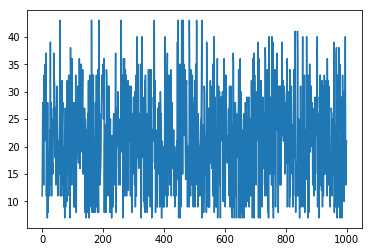

In [33]:
plt.plot(jList)

### So... What did I just do?

I'm not really sure, but the computer did run 2000 episodes of Connect Four and (possibly) trained the Q-network to play. I'm not really sure how to test it, and I've got to run to practice now, but I'll return to this when I get back.

Ok! So I messed around with some stuff above to save/reload models, and now below I'm going to try to implement a me-vs-machine game thingy.

In [35]:
# create a game
g = Game()

with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('./saved/model_1.meta')
    new_saver.restore(sess, './saved/model_1')
    
    print(sess.run(weights))
    print('\n\n\n')
    print(sess.run(biases))
    
    d = False
    while not d:
        print(g)
        # get human input
        while True:
            try:
                play = int(input("Human, enter move: ")) - 1
                _, r, d = g.play(play)
                break
            except:
                if g.isPlayable():
                    print("Error, try again")
                else:
                    d = True
                    break
        if d:
            break
        # then get computer input, first predict best move from Q-network
        print("Computer is thinking...")
        s = g.getState()
        a, allQ = sess.run([predict, Qout], {inputs: s.reshape((1,84))})
        print("Computer's thought process (Q-values):")
        print(allQ[0] / sum(allQ[0]))
        # then make the move
        print("Computer is making move...")
        while True:
            try:
                _, r, d = g.play(a[0])
                break
            except:
                if g.isPlayable():
                    a[0] = np.random.randint(7)
                else:
                    d = True
                    break
        print("Computer made move in column {}.".format(a[0] + 1))
    print("Winner was {}".format(g.getWinner()))
    print(g.board)

INFO:tensorflow:Restoring parameters from ./saved/model_1
{0: array([[ 0.01522182,  0.05012871, -0.01358052, ..., -0.03000379,
         0.00627438,  0.00569671],
       [-0.02572515, -0.02726461,  0.03115265, ..., -0.01452359,
        -0.02443748, -0.04083097],
       [-1.93446064,  0.09299606,  0.14876945, ..., -1.96367955,
        -1.5489862 ,  0.35264772],
       ..., 
       [-0.03523155,  0.02639039,  0.02654322, ...,  0.00727208,
         0.03915333, -0.00661762],
       [ 0.02023797,  0.04125898,  0.00477196, ...,  0.06124842,
         0.08910985,  0.08714246],
       [ 0.01869466,  0.07858135,  0.03476847, ...,  0.04388571,
         0.08855609,  0.05316246]], dtype=float32), 1: array([[ -1.67540383e+00,  -2.14153886e+00,  -1.73638785e+00,
         -2.05763841e+00,  -1.42030942e+00,  -1.68450487e+00,
         -1.48252487e+00,  -1.63393438e+00,  -1.66428149e+00,
         -2.01206374e+00,  -2.45002842e+00,  -2.18682528e+00,
         -1.55882907e+00,  -1.91150820e+00,  -1.73356438e

Human, enter move: 2
Computer is thinking...
Computer's thought process (Q-values):
[ 0.          0.16569631  0.1658933   0.16540219  0.16560212  0.18154785
  0.15585822]
Computer is making move...
Computer made move in column 6.
-	-	-	-	-	-	-	
-	-	-	-	-	-	-	
-	-	-	-	-	-	-	
-	-	-	-	-	-	-	
-	-	-	-	-	-	-	
-	1	-	-	-	2	-	
---	---	---	---	---	---	---	
1	2	3	4	5	6	7
current player is 1
Human, enter move: 2
Computer is thinking...
Computer's thought process (Q-values):
[ 0.          0.16569631  0.1658933   0.16540219  0.16560212  0.18154785
  0.15585822]
Computer is making move...
Computer made move in column 6.
-	-	-	-	-	-	-	
-	-	-	-	-	-	-	
-	-	-	-	-	-	-	
-	-	-	-	-	-	-	
-	1	-	-	-	2	-	
-	1	-	-	-	2	-	
---	---	---	---	---	---	---	
1	2	3	4	5	6	7
current player is 1
Human, enter move: 6
Computer is thinking...
Computer's thought process (Q-values):
[ 0.          0.16569631  0.1658933   0.16540219  0.16560212  0.18154785
  0.15585822]
Computer is making move...
Computer made move in column 6.
-	-	